In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import time
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,root_mean_squared_error
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
import itertools

from utils import clean_data
from utils import split_trajectories
from utils import replicate_initial_position_by_block
from utils import get_n_trajectories
from utils import plot_y_yhat
from utils import add_three_body_features

In [2]:
train = pd.read_csv('../data/X_train.csv')
test =  pd.read_csv('../data/X_test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')#This is a file with random numbers as predictions
                                                                #dans le futur fichier résultat ne pas mettre l'index

In [10]:
train_cleaned=clean_data(train)

In [16]:
train_after_split, validation_after_split, test_after_split = split_trajectories(train_cleaned)

In [17]:
train_entry=replicate_initial_position_by_block(train_after_split)
validation_entry=replicate_initial_position_by_block(validation_after_split)
test_entry=replicate_initial_position_by_block(test_after_split)

In [6]:
def validate_knn_regression(X_train, y_train, X_val, y_val, k_values=range(1,15)):
    """
    Validate KNN regression for a range of k values.
    Scales features and target, computes RMSE, and records training/inference times.
    """

    results = []

    # Scale features and target
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)

    y_train_scaled = scaler_y.fit_transform(y_train)
    
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, weights='distance')

        # Measure training time
        start_train = time.time()
        knn.fit(X_train_scaled, y_train_scaled)
        end_train = time.time()
        train_time = end_train - start_train

        # Measure inference time
        start_inf = time.time()
        y_val_pred_scaled = knn.predict(X_val_scaled)
        end_inf = time.time()
        inference_time = end_inf - start_inf

        # Inverse transform predictions
        y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)

        # Compute RMSE
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

        results.append({
            'k': k,
            'rmse': rmse,
            'train_time': train_time,
            'inference_time': inference_time
        })

        print(f"k = {k}, RMSE = {rmse:.5f}, Train time = {train_time:.3f}s, Inference time = {inference_time:.3f}s")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Plot RMSE vs k
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(results_df['k'], results_df['rmse'], marker='o')
    plt.xlabel("k")
    plt.ylabel("Validation RMSE")
    plt.title("KNN Regression: RMSE vs k")
    plt.grid(True)

    # Plot training/inference times vs k
    plt.subplot(1,2,2)
    plt.plot(results_df['k'], results_df['train_time'], marker='o', label='Training time')
    plt.plot(results_df['k'], results_df['inference_time'], marker='o', label='Inference time')
    plt.xlabel("k")
    plt.ylabel("Time (seconds)")
    plt.title("Training and Inference Time vs k")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return results_df

k = 1, RMSE = 1.10925, Train time = 6.456s, Inference time = 3.764s
k = 2, RMSE = 1.10528, Train time = 6.231s, Inference time = 3.029s
k = 3, RMSE = 1.10570, Train time = 4.638s, Inference time = 4.089s
k = 4, RMSE = 1.10032, Train time = 4.360s, Inference time = 3.524s
k = 5, RMSE = 1.10237, Train time = 5.292s, Inference time = 4.410s
k = 6, RMSE = 1.08881, Train time = 4.515s, Inference time = 3.638s
k = 7, RMSE = 1.07812, Train time = 5.463s, Inference time = 4.289s
k = 8, RMSE = 1.05350, Train time = 4.012s, Inference time = 4.776s
k = 9, RMSE = 1.04389, Train time = 5.108s, Inference time = 4.119s
k = 10, RMSE = 1.03540, Train time = 4.434s, Inference time = 5.749s
k = 11, RMSE = 1.02374, Train time = 4.714s, Inference time = 5.285s
k = 12, RMSE = 1.01214, Train time = 5.093s, Inference time = 5.284s
k = 13, RMSE = 1.00540, Train time = 4.141s, Inference time = 6.854s
k = 14, RMSE = 1.00192, Train time = 5.870s, Inference time = 6.935s


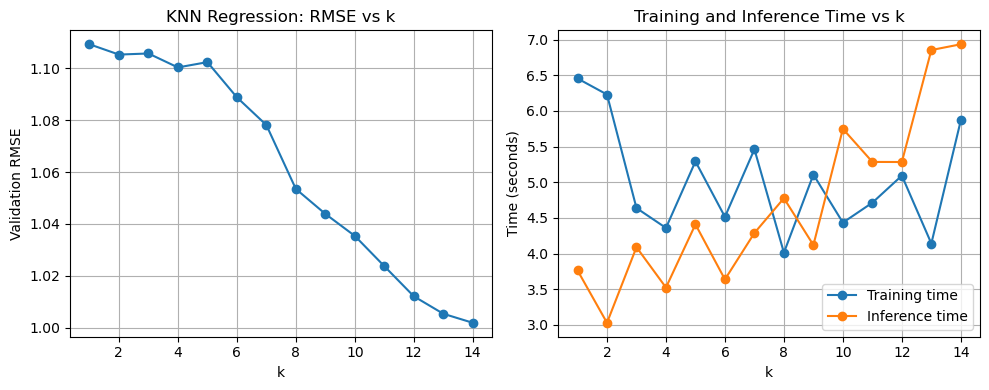

,k,rmse,train_time,inference_time
0,1,1.109253,6.455869,3.764249
1,2,1.105279,6.230673,3.029095
2,3,1.105699,4.638139,4.089328
3,4,1.100324,4.359690,3.523615
4,5,1.102367,5.292268,4.409621
5,6,1.088813,4.514736,3.637842
6,7,1.078123,5.462739,4.288854
7,8,1.053495,4.012401,4.776146
8,9,1.043887,5.107636,4.119482
9,10,1.035398,4.434064,5.749011


In [7]:
input_cols= [
    't',
    'x_1', 'y_1',
    'x_2', 'y_2',
    'x_3','y_3'
]

target_cols = ['x_1','y_1','x_2','y_2','x_3','y_3']

X_train = train_entry[input_cols]
X_val = validation_entry[input_cols]
X_test = test_entry[input_cols]


y_train = train_after_split[target_cols]
y_val = validation_after_split[target_cols]
y_test = test_after_split[target_cols]

validate_knn_regression(X_train, y_train, X_val, y_val, k_values=range(1,15))

In [18]:
X_train_enriched = add_three_body_features(train_entry)
X_val_enriched   = add_three_body_features(validation_entry)
X_test_enriched = add_three_body_features(test_entry)

In [16]:
groupes = {
    0: ['t', 'x_1', 'y_1', 'x_2', 'y_2'],  # toujours présents
    1: ['r_12', 'r_13', 'r_23'],
    2: ['inv_r_12', 'inv_r_13', 'inv_r_23'],
    3: ['r12_over_r13', 'r12_over_r23', 'r13_over_r23'],
    4: ['triangle_area'],
    5: ['d1_cm', 'd2_cm', 'd3_cm']
}

# Combinaisons possibles des groupes 1 à 5, jusqu'à taille 3
groupes_optionnels = [1, 2, 3, 4, 5]
combinaisons = []
for r in range(0, min(len(groupes_optionnels), 4)+1):  # 0 à 4 groupes choisis
    for subset in itertools.combinations(groupes_optionnels, r):
        combinaisons.append(subset)

print(f"Nombre total de combinaisons testées (max 4 groupes) : {len(combinaisons)}")

# Targets
target_cols = ['x_1','y_1','x_2','y_2','x_3','y_3']
y_train = train_after_split[target_cols].copy()
y_val   = validation_after_split[target_cols].copy()

# Valeurs de k à tester
k_values = [14]

results = []

for combo in combinaisons:
    # Construire la liste des features à utiliser
    features = groupes[0].copy()  # toujours présents
    for g in combo:
        features += groupes[g]

    # Sélection des features
    X_train_sel = X_train_enriched[features]
    X_val_sel   = X_val_enriched[features]

    # Standardisation
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train_sel)
    X_val_scaled   = scaler_X.transform(X_val_sel)
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_val_scaled   = scaler_y.transform(y_val)

    # Boucle sur les valeurs de k
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
        knn.fit(X_train_scaled, y_train_scaled)

        y_val_pred_scaled = knn.predict(X_val_scaled)
        y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)

        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

        results.append({
            'groupes': combo,
            'features': features,
            'k': k,
            'rmse': rmse
        })
        print(f"Groupes {combo}, k={k}, RMSE={rmse:.5f}")

# Trouver le meilleur résultat
best_result = min(results, key=lambda x: x['rmse'])
print("\n✅ Meilleur modèle :")
print(f"Groupes = {best_result['groupes']}, k = {best_result['k']}, RMSE = {best_result['rmse']:.5f}")
print(f"Features utilisées : {best_result['features']}")

Nombre total de combinaisons testées (max 4 groupes) : 31
Groupes (), k=14, RMSE=0.91511
Groupes (1,), k=14, RMSE=0.93642
Groupes (2,), k=14, RMSE=0.93246
Groupes (3,), k=14, RMSE=0.89351
Groupes (4,), k=14, RMSE=0.91460
Groupes (5,), k=14, RMSE=0.92362
Groupes (1, 2), k=14, RMSE=0.95057
Groupes (1, 3), k=14, RMSE=0.91752
Groupes (1, 4), k=14, RMSE=0.92799
Groupes (1, 5), k=14, RMSE=0.93786
Groupes (2, 3), k=14, RMSE=0.92925
Groupes (2, 4), k=14, RMSE=0.92339
Groupes (2, 5), k=14, RMSE=0.93492
Groupes (3, 4), k=14, RMSE=0.90265
Groupes (3, 5), k=14, RMSE=0.89707
Groupes (4, 5), k=14, RMSE=0.93001
Groupes (1, 2, 3), k=14, RMSE=0.94657
Groupes (1, 2, 4), k=14, RMSE=0.94677
Groupes (1, 2, 5), k=14, RMSE=0.94821
Groupes (1, 3, 4), k=14, RMSE=0.91021
Groupes (1, 3, 5), k=14, RMSE=0.91836
Groupes (1, 4, 5), k=14, RMSE=0.93080
Groupes (2, 3, 4), k=14, RMSE=0.92349
Groupes (2, 3, 5), k=14, RMSE=0.92570
Groupes (2, 4, 5), k=14, RMSE=0.93717
Groupes (3, 4, 5), k=14, RMSE=0.90226
Groupes (1, 2, 3

RMSE sur le jeu de test : 0.84040


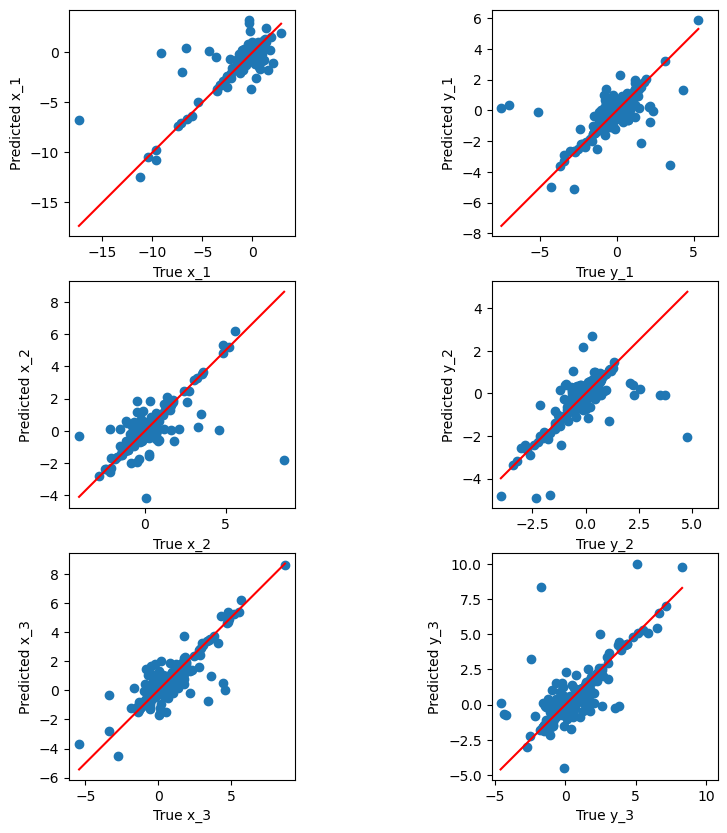

In [20]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Définition des groupes à utiliser
groupes = {
    0: ['t', 'x_1', 'y_1', 'x_2', 'y_2'],
    3: ['r12_over_r13', 'r12_over_r23', 'r13_over_r23'],
    5: ['d1_cm', 'd2_cm', 'd3_cm']
}

# Features à utiliser : groupes 0 + 3 + 5
features = groupes[0] + groupes[3] + groupes[5]

# Sélection des features
X_train_sel = X_train_enriched[features]
X_test_sel  = X_test_enriched[features]

y_train_sel = train_after_split[['x_1','y_1','x_2','y_2','x_3','y_3']]
y_test_sel  = test_after_split[['x_1','y_1','x_2','y_2','x_3','y_3']]

# Standardisation
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled  = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train_sel)
y_test_scaled  = scaler_y.transform(y_test_sel)

# Création du modèle KNN avec k=14 et poids distance
k = 14
knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
knn.fit(X_train_scaled, y_train_scaled)

# Prédiction sur le test
y_test_pred_scaled = knn.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

# Calcul du RMSE
rmse = np.sqrt(mean_squared_error(y_test_sel, y_test_pred))
print(f"RMSE sur le jeu de test : {rmse:.5f}")

# Visualisation vrais vs prédits
plot_y_yhat(y_test_sel.values, y_test_pred)


In [ ]:
X_train_enriched = add_three_body_features(train_entry)

X_test = test[['t','x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']].copy()
X_test.columns = ['t','x_1','y_1','x_2','y_2','x_3','y_3'] 
X_test_enriched  = add_three_body_features(X_test)

# Colonnes à utiliser
input_cols_enriched = [
    't',
    'x_1', 'y_1',
    'x_2', 'y_2',
    #'x_3', 'y_3',
    #'r_12', 'r_13', 'r_23',
    'inv_r_12', 'inv_r_13', 'inv_r_23',
    #'r12_over_r13', 'r12_over_r23', 'r13_over_r23',
    #'triangle_area',
    #'angle_1','angle_2','angle_3',
    #'d1_cm','d2_cm','d3_cm',
    #'Lz'
]

X_train_enriched_selected = X_train_enriched[input_cols_enriched]
X_test_enriched_selected  = X_test_enriched[input_cols_enriched]

# Targets
target_cols = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
y_train = train_after_split[target_cols].copy()

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_enriched_selected)
X_test_scaled  = scaler_X.transform(X_test_enriched_selected)
y_train_scaled = scaler_y.fit_transform(y_train)

knn_model = KNeighborsRegressor(n_neighbors=50, weights='distance')
knn_model.fit(X_train_scaled, y_train_scaled)

y_test_pred_scaled = knn_model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

output_df = pd.DataFrame(y_test_pred, columns=target_cols)
output_df.insert(0, 'Id', np.arange(len(output_df)))

output_df.to_csv('knn_submission.csv', index=False)
print("✅ Fichier 'knn_submission.csv' généré avec succès !")
